(transd_gaussian_mixture)=
# Part II: Trans-dimensional GMM

In this tutorial, we demonstrate how to use BayesBay to retrieve a Gaussian Mixture Model (GMM) while treating the number of components in the mixture as a free parameter, to be inferred from the data. If you haven't already, we recommend reviewing [Part I: Known Number of Mixture Components](gaussian_mixture); this provides a detailed explanation of the code required to define and solve the simpler problem of deriving a GMM with a predetermined number of mixture components.

In [1]:
import bayesbay as bb
from math import sqrt, pi
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(31)

In [2]:
MEANS = [140, 162, 177]  # Means of the Gaussians
STDS = [12, 5, 6]  # Standard deviations of the Gaussians
WEIGHTS = [0.4, 0.3, 0.3]  # Weights of each Gaussian in the mixture
N_SAMPLES = 10_000 # Number of samples to generate

In [3]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * sqrt(2*pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

## Observed data

In [4]:
assert np.isclose(sum(WEIGHTS), 1), "The weights must sum to 1."

def generate_random_samples(means, stds, weights):
    """Generate random samples for each component of the Gaussian mixture"""
    samples = []
    for mean, std, weight in zip(means, stds, weights):
        n_samples = int(N_SAMPLES * weight) # number of samples for each component
        samples.append(np.random.normal(mean, std, n_samples))
    samples = np.concatenate(samples)
    np.random.shuffle(samples)
    return samples

samples = generate_random_samples(MEANS, STDS, WEIGHTS)
data_obs, bins = np.histogram(samples, bins=50, density=True)
data_x = (bins[:-1] + bins[1:]) / 2 # Height associated with each data point

In [5]:
# Define the range of x-values (i.e., heights) over which to evaluate the PDF
x_min, x_max = min(MEANS) - 3 * max(STDS), max(MEANS) + 3 * max(STDS)
xs = np.linspace(x_min, x_max, 1000)

pdf_true = np.zeros_like(xs)
for mean, std, weight in zip(MEANS, STDS, WEIGHTS):
    pdf_true += weight * gaussian(xs, mean, std)

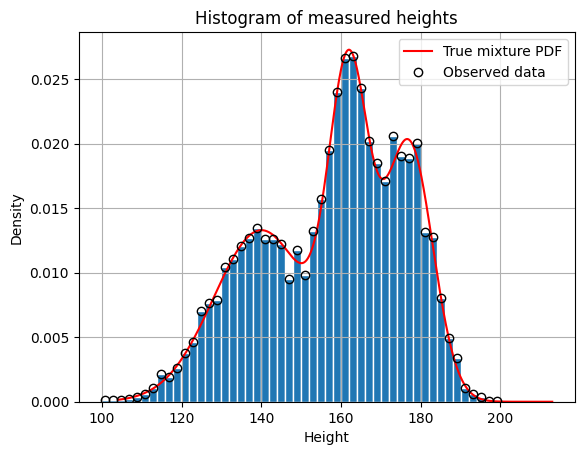

In [6]:
fig, ax = plt.subplots()
ax.set_title('Histogram of measured heights')
ax.hist(samples, bins=50, density=True, ec='w')
data_x = (bins[:-1] + bins[1:]) / 2 # take the midpoint of each bin
plt.plot(xs, pdf_true, label='True mixture PDF', color='r')
plt.plot(data_x, data_obs, 'ko', label='Observed data', markerfacecolor='None')

ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

### **Prior probability**

In [7]:
mean = bb.parameters.UniformParameter(name="mean", vmin=100, vmax=200, perturb_std=1)
std = bb.parameters.UniformParameter(name="std", vmin=1, vmax=20, perturb_std=1)
weight = bb.parameters.UniformParameter(name="weight", vmin=0, vmax=1, perturb_std=0.05)

### **Parameter space and parameterization**

As explained in [Part I: Known Number of Mixture Components](gaussian_mixture), the above free parameters should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). `ParameterSpace` can be conceptualized as an $n$-dimensional vector space, or similarly, as a specialized container. It not only groups a number of free parameters but also determines their dimensionality.

```{important}
The dimensionality of `ParameterSpace` can be treated as unknown by setting `n_dimensions=None` at the initialization of the class instance, as shown in the following block. This enables the definition of trans-dimensional inference problems.
```

In this tutorial's case, `ParameterSpace` will contain three distinct free parameters (namely, $\boldsymbol{\omega}$, $\boldsymbol{\mu}$, and $\boldsymbol{\sigma}$). Each parameter is a vector whose dimensionality will align with that of `ParameterSpace` throughout the inversion process. Whenever a dimension is added to or removed from `ParameterSpace` (via a [BirthPerturbation](../api/generated/bayesbay.perturbations.BirthPerturbation)/[DeathPerturbation](../api/generated/bayesbay.perturbations.DeathPerturbation)), the dimensionality of the free parameters linked to it is correspondingly adjusted.

In [8]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=None, # Trans-dimensional setting
    n_dimensions_min=1, # Minimum number of dimensions (i.e., Gaussians in the mixture)
    n_dimensions_max=7, # Maximum number of dimensions (i.e., Gaussians in the mixture)
    parameters=[mean, std, weight], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **Forward problem**

In [9]:
def _forward(means, stds, weights):
    weights /= np.sum(weights)
    data_pred = np.zeros_like(data_x)
    for i in range(len(means)):
        data_pred += weights[i] * gaussian(data_x, means[i], stds[i])
    return data_pred

def fwd_function(state: bb.State) -> np.ndarray:
    means = state["my_param_space"]['mean']
    stds = state["my_param_space"]['std']
    weights = state["my_param_space"]['weight']
    return _forward(means, stds, weights)

### **Observed data: the Target**

In [10]:
target = bb.Target("my_data", 
                   data_obs, 
                   std_min=0, 
                   std_max=0.01, 
                   std_perturb_std=0.001,
                   noise_is_correlated=True)

## Run the Bayesian sampling

In [11]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=10, 
    n_cpus=10
)
inversion.run(
    sampler=bb.samplers.SimulatedAnnealing(temperature_start=10),
    n_iterations=350_000, 
    burnin_iterations=100_000, 
    save_every=500, 
    verbose=False, 
)

## Retrieve the results and plot

In [12]:
results = inversion.get_results()
print(results.keys())

dict_keys(['my_param_space.n_dimensions', 'mean', 'std', 'weight', 'my_data.std', 'my_data.correlation', 'dpred'])


(array([0.000e+00, 2.325e+03, 1.996e+03, 6.110e+02, 6.700e+01, 1.000e+00,
        0.000e+00, 0.000e+00]),
 array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 8 artists>)

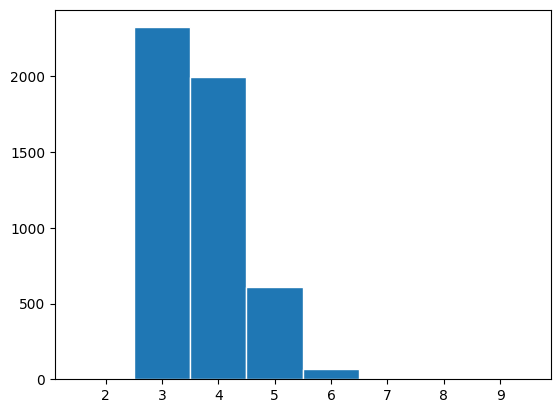

In [13]:
n_gaussians = results['my_param_space.n_dimensions']
plt.hist(n_gaussians, bins=np.arange(1.5, 10.5), ec='w')

In [14]:

idx = [i for i, n_comp in enumerate(n_gaussians) if n_comp==3]

def sort_mixture(means, stds, weights):
    indexes = [np.argsort(row) for row in means]
    for i, idx in enumerate(indexes):
        means[i] = means[i][idx]
        stds[i] = stds[i][idx]
        weights[i] = weights[i][idx]
    return means, stds, weights



In [15]:
means, stds, weights = sort_mixture(np.array([results["mean"][i] for i in idx]), 
                                    np.array([results["std"][i] for i in idx]), 
                                    np.array([results["weight"][i] for i in idx]))

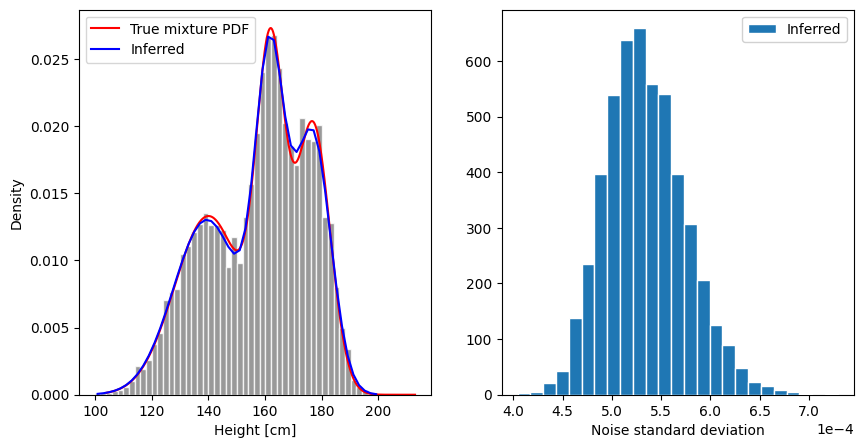

In [16]:


pdf_pred = _forward(np.median(means, axis=0), 
                    np.median(stds, axis=0), 
                    np.median(weights, axis=0)
                    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples, bins=50, density=True, ec='w', fc='gray', alpha=0.8)
ax1.plot(xs, pdf_true, label='True mixture PDF', color='r')
ax1.plot(data_x, pdf_pred, label='Inferred', color='b')
ax1.set_xlabel('Height [cm]')
ax1.set_ylabel('Density')
ax1.legend()

ax2.hist(results['my_data.std'], bins=25, ec='w', zorder=100, label='Inferred')
ax2.set_xlabel('Noise standard deviation')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend(framealpha=0.9)
plt.show()

In [17]:
np.median(means, axis=0)

array([139.4508316 , 161.74418401, 176.70373806])

In [18]:
np.median(stds, axis=0)

array([11.86155219,  5.13659375,  6.41714165])

In [19]:
np.median(weights, axis=0)

array([0.38708162, 0.30064446, 0.31165927])